## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Step #1 Compute the camera calibration using chessboard images

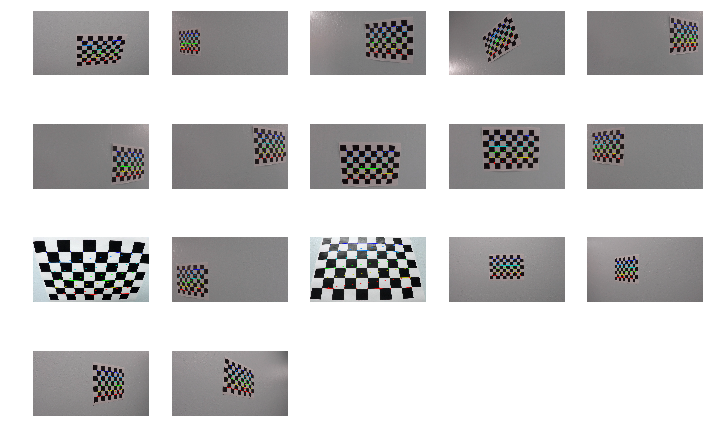

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
count = 0
plt.figure(figsize=(12, 8))
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(4, 5, count+1)
        plt.axis('off')
        plt.imshow(img)
        count += 1


## Image Undistortion

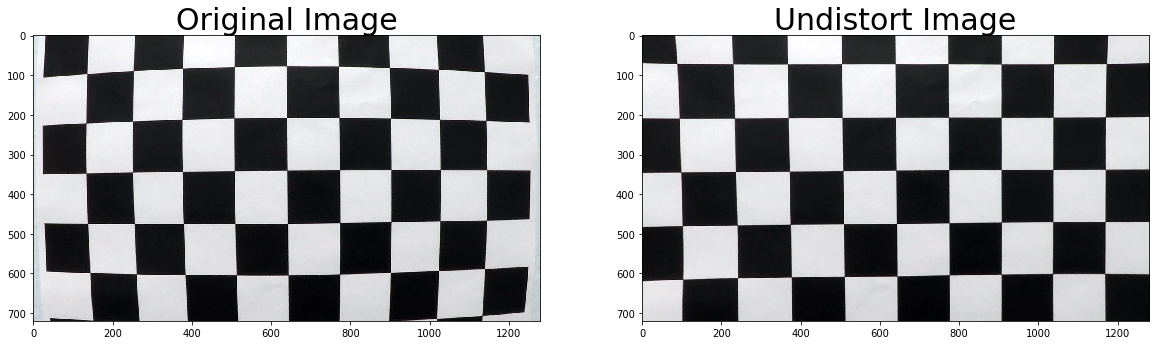

In [2]:
import pickle

#import an image to test
img_test = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img_test.shape[1], img_test.shape[0])

#camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img_test, mtx, dist, None, mtx)
cv2.imwrite('../output_image/undistort_image.jpg',dst)

#save the undistortion parameters for further use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('../output_images/camera_mtx_dist.p','wb'))
f, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistort Image', fontsize = 30)


## Step Two: Undistort Actual Signle Image

In [3]:
import numpy as np
import glob
from skimage import img_as_ubyte


def load_video_frames(frames):
    #load saved camera undistortion parameters
    with open(frames, 'rb') as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']

frames = '../output_images/camera_mtx_dist.p'
mtx, dist = load_video_frames(frames)

assert mtx is not None
assert mtx.shape == (3,3)
assert dist is not None

print('Camera parameter loaded')

def undistort_image(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

Camera parameter loaded


True

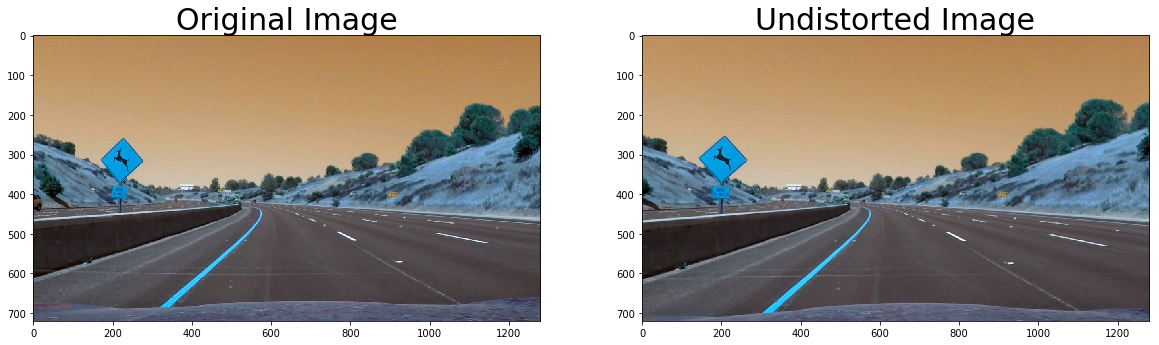

In [47]:
img_frame = '../test_images/test2.jpg'
img = cv2.imread(img_frame)

img_undistort = undistort_image(img, mtx, dist)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

cv2.imwrite('../output_images/test6_undist.jpg',img_undistort)

## Color & Threshold Selection
* Sobel method
* Binary Transform

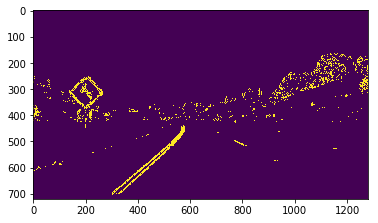

In [48]:
def binary_image(img, sobel_kernel=3, sc_thresh=(25, 255), sx_thresh=(20, 150)):
    binary_img = np.copy(img)
    hls = cv2.cvtColor(binary_img, cv2.COLOR_RGB2HLS)
    
    #find H, L, S channel sparately
    H_channel = hls[:,:,0] 
    L_channel = hls[:,:,1]
    S_channel = hls[:,:,2]
    
    #Using Sobel method to find gradient in x and y direction
    sobel_x = cv2.Sobel(S_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(S_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    
    #scale the output to 8-bit image 
    scaled_sobel = np.uint8(255*sobel_x_abs/np.max(sobel_x_abs))
    
    #Threshold color channel
    s_binary = np.zeros_like(S_channel)
    s_binary[(scaled_sobel > sc_thresh[0]) & (scaled_sobel < sc_thresh[1])] = 1
    
    #Threhold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
    
    # Stack each channel up
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))* 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    
    return combined_binary
    
result = binary_image(img_undistort)
plt.imshow(result)

## Perspective Correction

True

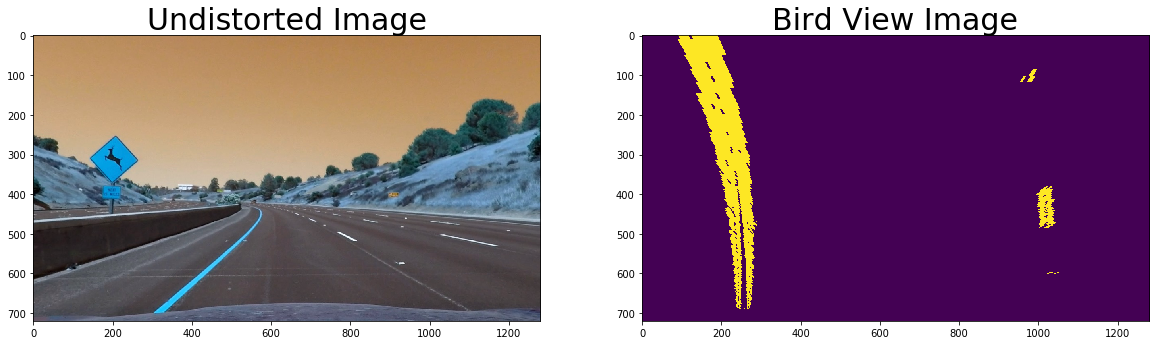

In [49]:
#build a bird view function to perform perfpective correction
def bird_view_img(img):
    
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    leftupvtx  = [580,460]
    rightupvtx = [700,460]
    leftbotvtx  = [280,680]
    rightbotvtx = [1100,680] 
     
    
    src = np.float32([leftupvtx, leftbotvtx,rightupvtx, rightbotvtx])
    #dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    #apply the transform to the original image
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags = cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M

img_warped, M = bird_view_img(result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_warped)
ax2.set_title('Bird View Image', fontsize=30)

cv2.imwrite('../output_images/test6_bird_view.jpg',img_warped)

True

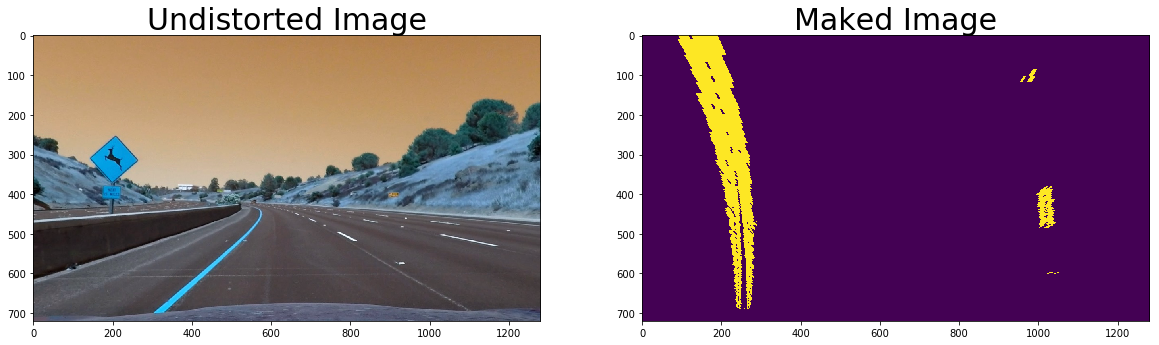

In [67]:
#Apply a mask on the bird view image to only show the lane line
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
       
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

vertices = np.array([[(0,0),(1150,0),(1150, 710),(0,710)]], dtype = np.int32)
bird_view = region_of_interest(img_warped, vertices)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(bird_view)
ax2.set_title('Maked Image', fontsize=30)

cv2.imwrite('../output_images/test6_masked.jpg',bird_view)

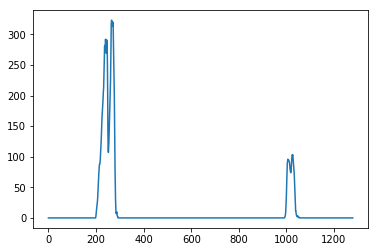

In [68]:
#find hot points through histogram method
def plot_hist(img, axis = 0):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    plt.plot(histogram)
    return histogram

img_binary = img_warped
histogram = plot_hist(img_binary)

True

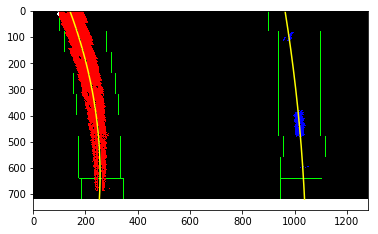

In [55]:
#Do a blind search to find the line and visualize the lines with sliding boxes

def find_lines_sw(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    polty_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        polty_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    return left_fit, right_fit, left_lane_inds, right_lane_inds, polty_data


left_fit, right_fit, left_lane_inds, right_lane_inds, polty_data = find_lines_sw(bird_view)

#visualize all data
nonzero = bird_view.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
### plot the figures
out_img = np.dstack((bird_view, bird_view, bird_view))*255
ploty = np.linspace(0, bird_view.shape[0]-1, bird_view.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
### Draw the windows on the visualization image
for polty in polty_data:
    cv2.rectangle(out_img,(polty[2],polty[0]),(polty[3],polty[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(polty[4],polty[0]),(polty[5],polty[1]),(0,255,0), 2)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
    
    
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(760, 0)

cv2.imwrite('../output_images/test6_find_lane.jpg',out_img)

(720, 0)

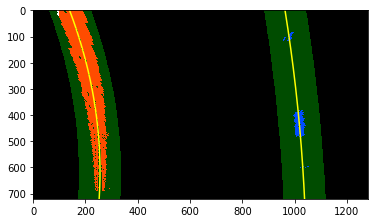

In [56]:
# define a function that search in a margin around the previous line position instead of do a search in blind search
def keep_find_lanes(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) 
                      & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) 
                       & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = keep_find_lanes(bird_view, left_fit, right_fit)

#using new data to generate new lane line data
ploty = np.linspace(0, bird_view.shape[0]-1, bird_view.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx2 = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

out_img = np.dstack((bird_view, bird_view, bird_view))*255
window_img = np.zeros_like(out_img)
margin = 80

nonzero = bird_view.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [69]:
#measuring the curvature
def find_curv(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):   
   
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


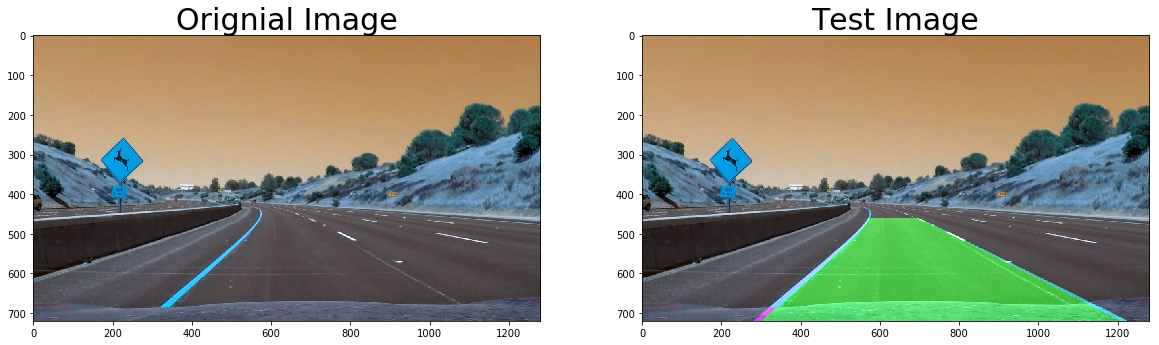

In [72]:
#transfer the curve lane to the real world image
def to_world_image(image, binary_warped, Minv, l_fit, r_fit):
     
    new_img = np.copy(image)
    if l_fit is None or r_fit is None:
        return image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


Minv = np.linalg.inv(M)
output = to_world_image(img, bird_view, Minv, left_fit_new, right_fit_new)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(output)
ax2.set_title('Test Image', fontsize=30)

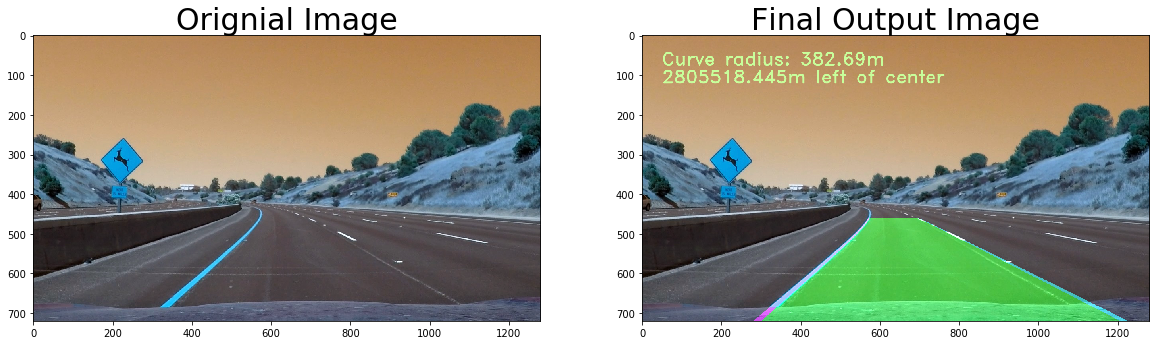

In [73]:
#write words on frames
def draw_data(img, radius, center_offset):
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(new_img, text, (50,75), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
        
    abs_center_offset = abs(center_offset)
    text = '{:04.3f}'.format(abs_center_offset) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (50,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

left_curverad, right_curverad, offset_from_center = find_curv(bird_view,left_fitx, right_fitx,left_lane_inds, right_lane_inds)
final_output = draw_data(output, (left_curverad+right_curverad)/2, offset_from_center )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(final_output)
ax2.set_title('Final Output Image', fontsize=30)

In [64]:
## Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None


## Test on real video


In [74]:
#pipline of the program
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(input_image):
    
    ksize = 9
    d_thresh  = (0.7, 1.2)
    sc_thresh=(110, 255)
    sx_thresh=(20, 100)
    
    new_img = np.copy(input_image)
    
    img_undist = undistort_image(new_img, mtx, dist)
    warped, M1 = bird_view_img(img_undist)
    Minv = np.linalg.inv(M1)
    binary = binary_image(warped, sobel_kernel=ksize, sc_thresh=sc_thresh, sx_thresh=sx_thresh )
    vertices = np.array([[(120, 710),(120, 0), (1150, 0), (1200,710)]], dtype=np.int32)
    masked_binary = region_of_interest(binary, vertices)
    
    l_fit, r_fit, l_lane_inds, r_lane_inds, _ = find_lines_sw(masked_binary)
    img_out1 = to_world_image(new_img, masked_binary , Minv, l_fit, r_fit)
    left_curverad, right_curverad, avg_radius_meters = find_curv(masked_binary ,l_fit, r_fit,l_lane_inds,r_lane_inds)
    img_out = draw_data(img_out1, (left_curverad+ right_curverad)/2, avg_radius_meters)
    
    '''
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = find_lines_sw(binary)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = keep_find_lanes(binary, l_line.best_fit, r_line.best_fit)
    #print(l_fit)
    #print(r_fit)
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    print(l_line.best_fit)
    if l_line.best_fit is not None and r_line.best_fit is not None:
        
        img_out1 = to_real_world_image(new_img, binary, Minv, l_line.best_fit, r_line.best_fit)
        left_curverad, right_curverad, avg_radius_meters = find_curv(binary,l_line.best_fit, r_line.best_fit,l_lane_inds,r_lane_inds)
        img_out = draw_data(img_out1, (left_curverad+ right_curverad)/2, avg_radius_meters)
    
    else:
        img_out = new_img
    '''    
    return img_out

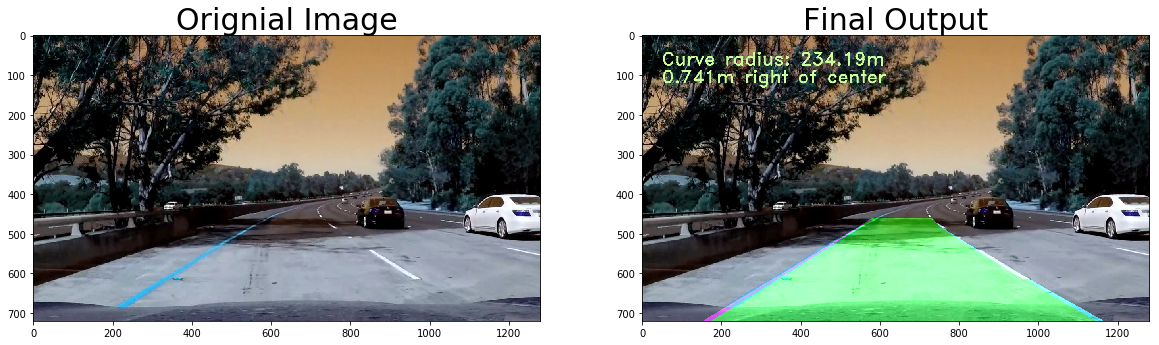

In [66]:
FILTER_SIZE = 20
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

l_line = Line()
r_line = Line()

test_image1 = '../test_images/test5.jpg'
test_image2 = cv2.imread(test_image1)
r = process_image(test_image2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image2)
ax1.set_title('Orignial Image', fontsize=30)
ax2.imshow(r)
ax2.set_title('Final Output', fontsize=30)

In [17]:

project_video_output = "../project_video_output.mp4"
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:14<00:00,  9.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

Wall time: 2min 14s


In [63]:
project_video_output1 = "challenge_video_output.mp4"
clip2 = VideoFileClip("../challenge_video.mp4")
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(project_video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:53<00:00,  9.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 54.2 s
